# Quantitative study on the induction of mRNA and its stability

Author: Anna B. Matuszyńska <a href="https://orcid.org/0000-0003-0882-6088"><img src="https://orcid.org/assets/vectors/orcid.logo.icon.svg" width=15></a>

In this notebook we explore the ideas presented in the original work by Hargrove and Schmidt [1] and White, Brewer and Wilson [2] on the effect that changing the rate of synthesis and degradation of mRNA would have on the final concentration. We play with the simplest, well established mathematical model based on a single compartment, with zero-order rate kinetics for mRNA synthesis and first-order rate of decay. 

This notebook aims at further supporting hypotheses generated by **Srimeenakshi Sankaranarayanan**, Carl Haag, Patrick Petzsch, Karl Köhrer, Kathi Zarnack and **Michael Feldbrügge** in their manuscript.

[1] Hargrove,J.L.; Schmidt, F. H. [The role of mRNA and protein stability in gene expression.](https://faseb.onlinelibrary.wiley.com/doi/10.1096/fasebj.3.12.2676679) *FASEB J*. 3: 2360-2370; 1989.

[2] White, E.J.F.; Brewer, G.; Wilson, G.M. [Post-transcriptional control of gene expression by AUF1:
Mechanisms, physiological targets, and regulation.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3664190/) *Biochim Biophys Acta.* 1829(0): 680–688; 2013.

In [52]:
%matplotlib inline

import numpy as np
import pandas

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from modelbase.ode import Model, Simulator, mca
from modelbase.ode import ratelaws as rl

mRNA concentrations can be modified by altering synthesis and/or degradation rates

\begin{equation}
\frac{d\mathrm{[mRNA]}}{dt} = v_\mathrm{synthesis} - v_\mathrm{degradation} = 0
\end{equation}

\begin{equation}
v_\mathrm{synthesis} = k_\mathrm{synthesis}
\end{equation}

\begin{equation}
v_\mathrm{degradation} = k_\mathrm{decay} \cdot \text{[mRNA]}
\end{equation}

From [2] we assume that the rate of mRNA decay is inversly related to the mRNA half-life $(t_{1/2})$.


\begin{equation}
t_{1/2} = \frac{ln 2}{k_\mathrm{decay}}
\end{equation}

hence the longer half-time translates to slower rate of mRNA decay.

This behaviour can be observed by simulating change in the mRNA concentration over time with various half times at the same rate of mRNA synthesis for two strains: *Mob1* and *Arl1*.


- *Mob1*: half-life 8 minutes, initial concentration 36, steady state 308,
- *Arl1*: half-life 16 minutes, initial concentration 52, steady stated 165.

In [53]:
def decay(halftime):
    """ return the rate of mRNA decay for the given half-life"""
    return np.log(2)/halftime

### Define model

In [54]:
m = Model()

m.add_compounds(["mRNA"])
m.add_parameters({'kSynth': 1, 'kDecay': decay(0.0578)})

def constant(k):
    return k

def mass_action_1s(s, kp):
    """Irreversible mass-action function with 1 substrate
    Arguments:
    s -> Substrate
    kp -> positive rate constant 
    """
    return kp * s

m.add_reaction_from_args(
    rate_name = "vSynth", #This should be a unique name that helps you identify the appropriate reaction
    function = constant, #This is the appropriate function you created beforehand
    stoichiometry = {"mRNA": 1}, #This is a dictionary of the compounds with their respective stochiometry in this specific reaction
    args = ["kSynth"] #this is a list of all arguments passed to the function, in their respective oder
)

m.add_reaction_from_args(
    rate_name = "vDecay",
    function = mass_action_1s,
    stoichiometry = {"mRNA": -1},
    args = ["mRNA", "kDecay"],
    reversible = False
)

## Effect of the half/time on the mRNA concentration over time

Assuming the same rate of mRNA synthesis but 10 fold-different rate of degradation we simulate the induction of mRNA and mark the halftime of reaching the steady-state. This simulation reproduces the original Figure 2 from [1].

1.2007767080650065
11.93878857073617


Text(0.5, 1.0, 'Induction of mRNA for the same synthesis and 10-fold increased rate of decay')

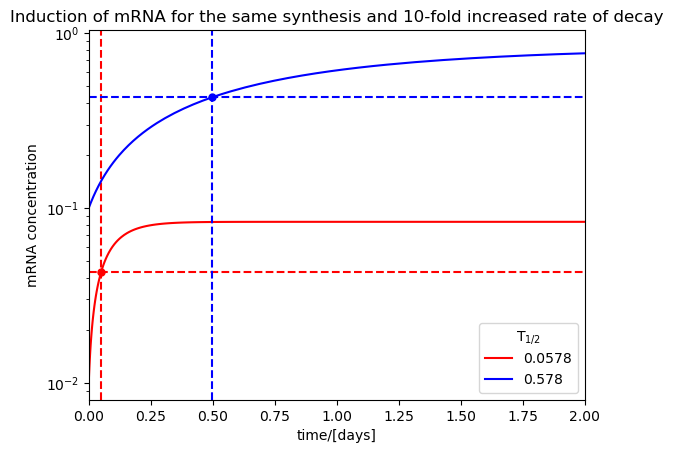

In [55]:
colors = ['r', 'b']

for i,j,k in zip([0.1,1.],colors,[0.0578, 0.578]):
    s = Simulator(m)
    y0 = {'mRNA': 0.1*i}
    s.update_parameters({'kSynth': 1., 'kDecay': decay(k)})
    s.initialise(y0)
    t, y = s.simulate(20) #Actually simulating the model until the given time point. The specifc time steps are stored as an array in the variable t
                            #and the different concentrations in a nested array
  
    plt.plot(t,y, label = str(k), color=j)
    plt.xlabel("time/[days]")
    
    #print(y[np.where(y <= 0.5 * y[-1])])
    
    findhalf = min([i for i in range(len(y)) if y[i] >= 0.5 * y[-1]])
    
    plt.plot(t[findhalf], 
             y[findhalf], marker='o', color=j, markersize=5)
    
    plt.axhline(y=y[findhalf], xmin=0, xmax=1, color=j, linestyle = "--")
    plt.axvline(x=t[findhalf], color=j, linestyle = "--")
    print(t[findhalf]*24)
    
# Setting the Y-axis scale to logarithmic
plt.yscale('log')
plt.ylabel('mRNA concentration')
plt.xlim(0,2)
plt.legend(title="T$_{1/2}$")
plt.title("Induction of mRNA for the same synthesis and 10-fold increased rate of decay")

If we now repeat the experiment, but instead of changing the half-time we will increase 10 fold rate of synthesis we observe that the change does not affect the time of reaching half of the steady state concentration for the given parameters set and the starting concentration of mRNA.

Text(0.5, 1.0, 'Induction of mRNA for the same synthesis and 10-fold increased decay')

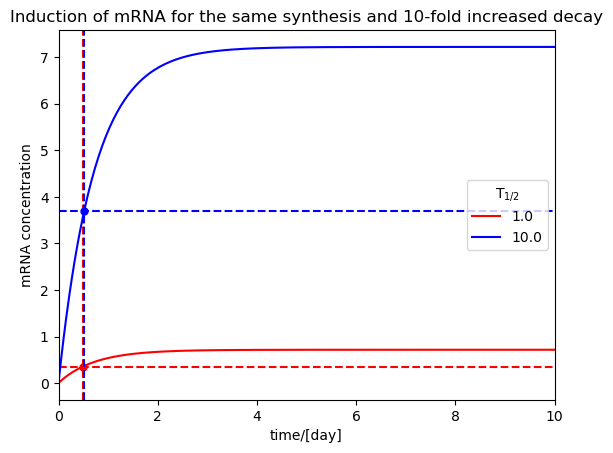

In [56]:
for i,j in zip([1.,10.],colors):
    s = Simulator(m)
    y0 = {'mRNA': 0.01}
    s.update_parameters({'kSynth': i, 'kDecay': decay(0.5)})
    s.initialise(y0)
    t, y = s.simulate(10) #Actually simulating the model until the given time point. The specifc time steps are stored as an array in the variable t
                            #and the different concentrations in a nested array
    
    plt.plot(t,y, label = str(i), color=j)
    plt.ylabel("mRNA concentration")
    plt.xlabel("time/[day]")
    
    #print(y[np.where(y <= 0.5 * y[-1])])
    
    findhalf = min([hl for hl in range(len(y)) if y[hl] >= 0.5 * y[-1]])
    
    plt.plot(t[findhalf], 
             y[findhalf], marker='o', color=j, markersize=5)
    
    plt.axhline(y=y[findhalf], xmin=0, xmax=1, color=j, linestyle = "--")
    plt.axvline(x=t[findhalf], color=j, linestyle = "--")

    
plt.xlim(0,10)
plt.legend(title="T$_{1/2}$")
plt.title("Induction of mRNA for the same synthesis and 10-fold increased decay")

## Comparative analysis of *Mob1* in wildtype and *khd4*$\Delta$
rate of synthesis kept the same, half time two times longer for the mutant

5.0927999999999995
11.951999999999998


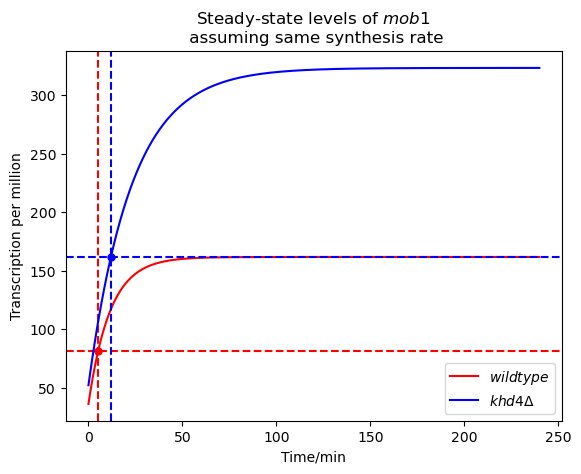

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i,j,k, l in zip([36.,52.],colors, ['$wildtype$','$\it{khd4}\Delta$'], [8, 16]):
    s_mob1 = Simulator(m)
    y0 = {'mRNA': i}
    m.update_parameters({'kSynth': 14, 'kDecay': decay(l)})
    s_mob1.initialise(y0)
    t, y = s_mob1.simulate(4*60, steps=100000) #Actually simulating the model until the given time point. The specifc time steps are stored as an array in the variable t
                                    #and the different concentrations in a nested array
    ax.plot(s_mob1.get_time(), s_mob1.get_variable('mRNA'), label = k, color=j)
    findhalf = min([hl for hl in range(len(y)) if y[hl] >= 0.5 * y[-1]])

    plt.plot(t[findhalf], 
             y[findhalf], marker='o', color=j, markersize=5)

    plt.axhline(y=y[findhalf], xmin=0, xmax=1, color=j, linestyle = "--")
    plt.axvline(x=t[findhalf], color=j, linestyle = "--")
    print(t[findhalf])

plt.xlabel("Time/min")
plt.ylabel("Transcription per million") #modelbase gives us the option to plot immediately through our Simulator() object,
                                                                        #but we could have also done it with the t and y variables appointed earlier.
plt.title('Steady-state levels of $\it{mob1}$ \n assuming same synthesis rate')
ax.legend()        

rate of synthesis two times faster for the mutant, half time kept the same

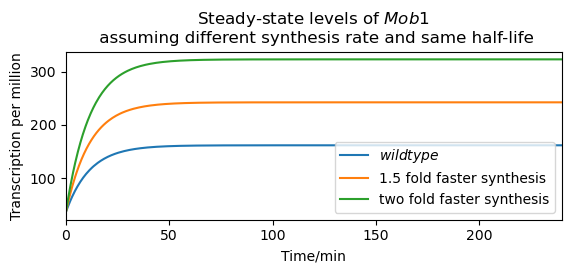

In [7]:
fig = plt.figure()
ax = fig.add_subplot(211)

synthesis = 14
s_mob1 = Simulator(m)
y0 = {'mRNA': 36}
m.update_parameters({'kSynth': synthesis, 'kDecay': decay(8)})
s_mob1.initialise(y0)
t, y = s_mob1.simulate(4*60) #Actually simulating the model until the given time point. The specifc time steps are stored as an array in the variable t
                                #and the different concentrations in a nested array
ax.plot(s_mob1.get_time(), s_mob1.get_variable('mRNA'), label = '$wildtype$')


s_arl1 = Simulator(m)
y0 = {'mRNA': 36}
m.update_parameters({'kSynth': 1.5*synthesis, 'kDecay': decay(8)})
s_arl1.initialise(y0)
t, y = s_arl1.simulate(4*60) #Actually simulating the model until the given time point. The specifc time steps are stored as an array in the variable t
                                #and the different concentrations in a nested array
ax.plot(s_arl1.get_time(), s_arl1.get_variable('mRNA'), label = '1.5 fold faster synthesis')

plt.xlim(0, 240)
plt.xlabel("Time/min")
plt.ylabel("Transcription per million") #modelbase gives us the option to plot immediately through our Simulator() object,
                                                                        #but we could have also done it with the t and y variables appointed earlier.
plt.title('Steady-state levels of $\it{Mob1}$ \n assuming different synthesis rate and same half-life')
ax.legend()   


s_arl1 = Simulator(m)
y0 = {'mRNA': 36}
m.update_parameters({'kSynth': 2*synthesis, 'kDecay': decay(8)})
s_arl1.initialise(y0)
t, y = s_arl1.simulate(4*60) #Actually simulating the model until the given time point. The specifc time steps are stored as an array in the variable t
                                #and the different concentrations in a nested array
ax.plot(s_arl1.get_time(), s_arl1.get_variable('mRNA'), label = 'two fold faster synthesis')

plt.xlim(0, 240)
plt.xlabel("Time/min")
plt.ylabel("Transcription per million") #modelbase gives us the option to plot immediately through our Simulator() object,
                                                                        #but we could have also done it with the t and y variables appointed earlier.
plt.title('Steady-state levels of $\it{Mob1}$ \n assuming different synthesis rate and same half-life')
ax.legend()        

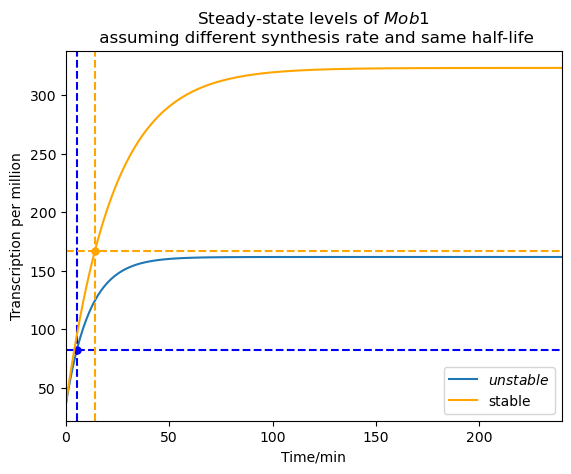

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)

synthesis = 14
s_mob1 = Simulator(m)
y0 = {'mRNA': 36}
m.update_parameters({'kSynth': synthesis, 'kDecay': decay(8)})
s_mob1.initialise(y0)
t, y = s_mob1.simulate(4*60) #Actually simulating the model until the given time point. The specifc time steps are stored as an array in the variable t
                                #and the different concentrations in a nested array
ax.plot(s_mob1.get_time(), s_mob1.get_variable('mRNA'), label = '$unstable$')
findhalf = min([hl for hl in range(len(y)) if y[hl] >= 0.5 * y[-1]])

plt.plot(t[findhalf], 
         y[findhalf], marker='o', color=j, markersize=5)

plt.axhline(y=y[findhalf], xmin=0, xmax=1, color=j, linestyle = "--")
plt.axvline(x=t[findhalf], color=j, linestyle = "--")



s_arl1 = Simulator(m)
y0 = {'mRNA': 36}
m.update_parameters({'kSynth': synthesis, 'kDecay': decay(16)})
s_arl1.initialise(y0)
t, y = s_arl1.simulate(4*60) #Actually simulating the model until the given time point. The specifc time steps are stored as an array in the variable t
                                #and the different concentrations in a nested array
ax.plot(s_arl1.get_time(), s_arl1.get_variable('mRNA'), label = 'stable', color='orange')
findhalf = min([hl for hl in range(len(y)) if y[hl] >= 0.5 * y[-1]])

plt.plot(t[findhalf], 
         y[findhalf], marker='o', color='orange', markersize=5)

plt.axhline(y=y[findhalf], xmin=0, xmax=1, color='orange', linestyle = "--")
plt.axvline(x=t[findhalf], color='orange', linestyle = "--")

plt.xlim(0, 240)
plt.xlabel("Time/min")
plt.ylabel("Transcription per million") #modelbase gives us the option to plot immediately through our Simulator() object,
                                                                        #but we could have also done it with the t and y variables appointed earlier.
plt.title('Steady-state levels of $\it{Mob1}$ \n assuming different synthesis rate and same half-life')
ax.legend()   

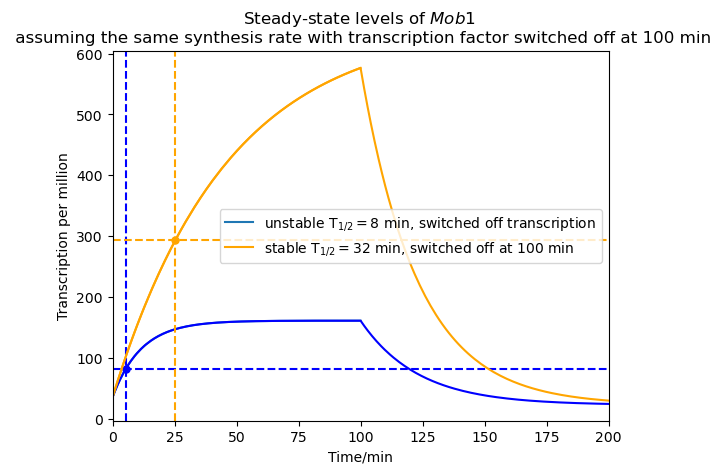

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)

synthesis = 14
time_run = 200
s_mob1 = Simulator(m)
y0 = {'mRNA': 36}
m.update_parameters({'kSynth': synthesis, 'kDecay': decay(8)})
s_mob1.initialise(y0)
t, y = s_mob1.simulate(100) #Actually simulating the model until the given time point. The specifc time steps are stored as an array in the variable t
                                #and the different concentrations in a nested array
        
ax.plot(s_mob1.get_time(), s_mob1.get_variable('mRNA'), label = 'unstable T$_{1/2}=$8 min, switched off transcription')
findhalf = min([hl for hl in range(len(y)) if y[hl] >= 0.5 * y[-1]])

plt.plot(t[findhalf], 
         y[findhalf], marker='o', color='blue', markersize=5)

plt.axhline(y=y[findhalf], xmin=0, xmax=1, color=j, linestyle = "--")
plt.axvline(x=t[findhalf], color=j, linestyle = "--")

m.update_parameters({'kSynth': 1., 'kDecay': decay(16)})
t, y = s_mob1.simulate(time_run) #Actually simulating the model until the given time point. The specifc time steps are stored as an array in the variable t
                                #and the different concentrations in a nested array

ax.plot(s_mob1.get_time(), s_mob1.get_variable('mRNA'), color = 'blue')

s_arl1 = Simulator(m)
y0 = {'mRNA': 36}
m.update_parameters({'kSynth': 14, 'kDecay': decay(32)})
s_arl1.initialise(y0)
t, y = s_arl1.simulate(100) #Actually simulating the model until the given time point. The specifc time steps are stored as an array in the variable t
                                #and the different concentrations in a nested array
ax.plot(s_arl1.get_time(), s_arl1.get_variable('mRNA'), label = 'stable T$_{1/2}=$32 min, switched off at 100 min', color='orange')
findhalf = min([hl for hl in range(len(y)) if y[hl] >= 0.5 * y[-1]])

plt.plot(t[findhalf], 
         y[findhalf], marker='o', color='orange', markersize=5)

plt.axhline(y=y[findhalf], xmin=0, xmax=1, color='orange', linestyle = "--")
plt.axvline(x=t[findhalf], color='orange', linestyle = "--")

s_arl1.update_parameters({'kSynth': 1.0, 'kDecay': decay(16)})
t, y = s_arl1.simulate(time_run) #Actually simulating the model until the given time point. The specifc time steps are stored as an array in the variable t
                                #and the different concentrations in a nested array

ax.plot(s_arl1.get_time(), s_arl1.get_variable('mRNA'), color = 'orange')


plt.xlim(0, time_run)
plt.xlabel("Time/min")
plt.ylabel("Transcription per million") #modelbase gives us the option to plot immediately through our Simulator() object,
                                                                        #but we could have also done it with the t and y variables appointed earlier.
plt.title('Steady-state levels of $\it{Mob1}$ \n assuming the same synthesis rate with transcription factor switched off at 100 min')
ax.legend()   

# Change in steady state levels of Mob1 during morphological transition from yeast to hyphae

Assumptions for parametrization of the toy model:

- In wildtype (mRNA levels are in TPM):

  - Steady-state level in Yeast stage : 30 TPM

  - Steady-state level in hyphal stage : 300 TPM

- In khd4∆ (mRNA levels are in TPM):

  - Steady-state level in Yeast stage : 80 TPM
  - Steady-state level in hyphal stage : 800 TPM

- mRNA synthesis is set to begin after 10 minutes 

- mRNA synthesis stops once the steady-state level is reached

Half-life of Mob1
- In wildtype: 8 mins
- In khd4D: 16 mins


In [59]:
def detect_steady_state(s, tol=1e-4):
    """ return teh index for which the steady state was reached
    where steady state is defined with a given tolerance level"""
    y = s.results[0]
    index_of_element = -1
    for i in range(y.size):
        if y[i+1]-y[i] < tol:
            index_of_element = i
            return i


81.84
169.715
162.145


43

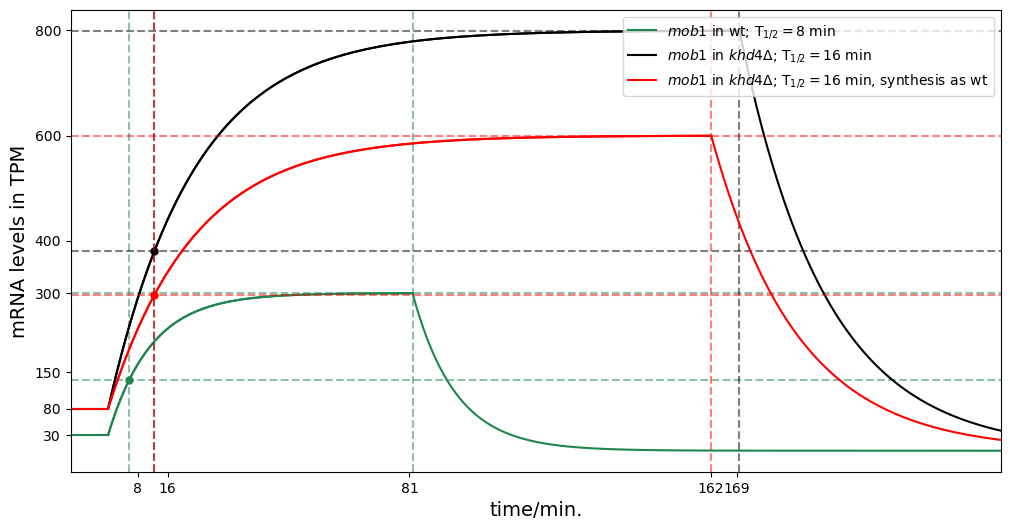

In [80]:
colors = ["#20854E", 'k', 'red']
strains={"mob1-wt": [30, np.log(2)/8 * 300, 8, "#20854E", '$\it{mob1}$ in wt; T$_{1/2}=$8 min'],
        "mob1-khd4": [80, np.log(2)/16 * 800, 16, "k", '$\it{mob1}$ in $\it{khd4}\Delta$; T$_{1/2}=$16 min'],
        "mob1-khd4-wt": [80, np.log(2)/8 * 300, 16, "red", '$\it{mob1}$ in $\it{khd4}\Delta$; T$_{1/2}=$16 min, synthesis as wt']
        }

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
plt.xlim(-10,240)

time_steady = [] # collect the numerical solution to steady state to put on the x-axis
findhalf = []

for i in strains.keys():
    ax.plot([-50, 0],[strains[i][0], strains[i][0]], color=strains[i][3])
    s = Simulator(m)
    y0 = {'mRNA': strains[i][0]}
    m.update_parameters({'kSynth': strains[i][1], 'kDecay': decay(strains[i][2])})
    s.initialise(y0)
    t, y = s.simulate(500, steps=100000, **{'atol':1e-2}) #Simulating further than the steady state
    
    index_steady = detect_steady_state(s) # identifying actual steady state
    time_steady.append(s.time[0][index_steady])
    
    s = Simulator(m) # resetting the simulator and runnig for precise time
    y0 = {'mRNA': strains[i][0]}
    m.update_parameters({'kSynth': strains[i][1], 'kDecay': decay(strains[i][2])})
    s.initialise(y0)
    print(time_steady[-1])
    t, y = s.simulate(time_steady[-1]) 
    
    ax.plot(s.get_time(), s.get_variable('mRNA'), color = strains[i][3], label = strains[i][4])
    findhalf = max([hl for hl in range(len(y)) if y[hl] <= 0.5 * y[-1]])

    #add half-times
    plt.axhline(y=y[findhalf], xmin=0, xmax=1, color = strains[i][3], alpha=0.5, linestyle = "--")
    plt.axvline(x=t[findhalf], color = strains[i][3], alpha=0.5, linestyle = "--")
    
    # add steady state levels
    plt.axhline(y=y[-1], xmin=0, xmax=1, color = strains[i][3], alpha=0.5, linestyle = "--")
    plt.axvline(x=t[-1], color = strains[i][3], alpha=0.5, linestyle = "--")
    
    plt.plot(t[findhalf], 
             y[findhalf], marker='o', color = strains[i][3], markersize=5)
    
    # switch off transcription completely
    s.update_parameters({'kSynth': 0})
    t, y = s.simulate(500) #Actually simulating the model until the given time point. The specifc time steps are stored as an array in the variable t
                                    #and the different concentrations in a nested array

    ax.plot(s.get_time(), s.get_variable('mRNA'), color = strains[i][3])


plt.xticks([8, 16, int(time_steady[0]), int(time_steady[1]), int(time_steady[2])])
plt.yticks([30, 80, 150, 300, 400, 600, 800])
plt.legend(loc="upper right", fontsize=10)
plt.ylabel('mRNA levels in TPM', fontsize = 14)
plt.xlabel("time/min.", fontsize = 14)
#plt.grid()
plt.savefig('YeastToHyphae.svg')
findhalf

81.84
169.715


IndexError: list index out of range

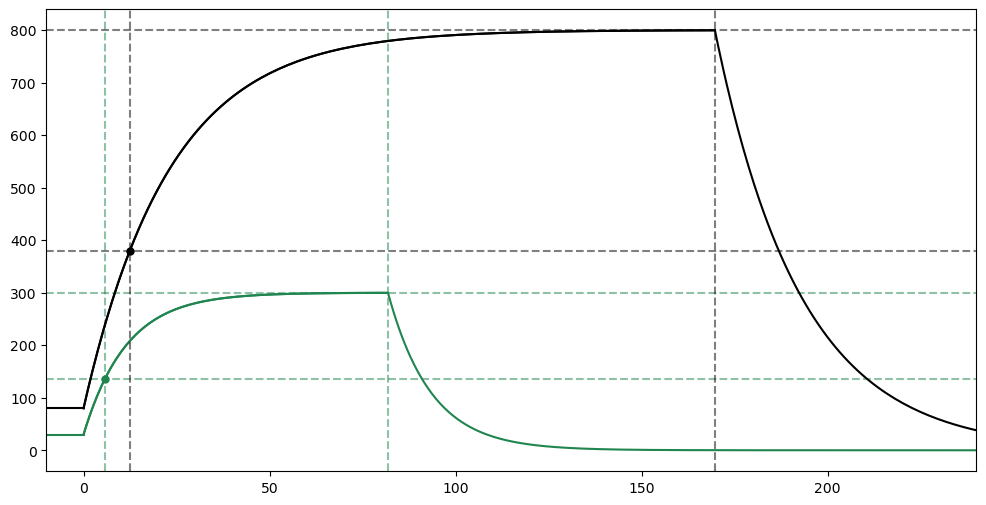

In [81]:
colors = ["#20854E", 'k', 'red']
strains={"mob1-wt": [30, np.log(2)/8 * 300, 8, "#20854E", '$\it{mob1}$ in wt; T$_{1/2}=$8 min'],
        "mob1-khd4": [80, np.log(2)/16 * 800, 16, "k", '$\it{mob1}$ in $\it{khd4}\Delta$; T$_{1/2}=$16 min'],
        }

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
plt.xlim(-10,240)

time_steady = [] # collect the numerical solution to steady state to put on the x-axis
findhalf = []

for i in strains.keys():
    ax.plot([-50, 0],[strains[i][0], strains[i][0]], color=strains[i][3])
    s = Simulator(m)
    y0 = {'mRNA': strains[i][0]}
    m.update_parameters({'kSynth': strains[i][1], 'kDecay': decay(strains[i][2])})
    s.initialise(y0)
    t, y = s.simulate(500, steps=100000, **{'atol':1e-2}) #Simulating further than the steady state
    
    index_steady = detect_steady_state(s) # identifying actual steady state
    time_steady.append(s.time[0][index_steady])
    
    s = Simulator(m) # resetting the simulator and runnig for precise time
    y0 = {'mRNA': strains[i][0]}
    m.update_parameters({'kSynth': strains[i][1], 'kDecay': decay(strains[i][2])})
    s.initialise(y0)
    print(time_steady[-1])
    t, y = s.simulate(time_steady[-1]) 
    
    ax.plot(s.get_time(), s.get_variable('mRNA'), color = strains[i][3], label = strains[i][4])
    findhalf = max([hl for hl in range(len(y)) if y[hl] <= 0.5 * y[-1]])

    #add half-times
    plt.axhline(y=y[findhalf], xmin=0, xmax=1, color = strains[i][3], alpha=0.5, linestyle = "--")
    plt.axvline(x=t[findhalf], color = strains[i][3], alpha=0.5, linestyle = "--")
    
    # add steady state levels
    plt.axhline(y=y[-1], xmin=0, xmax=1, color = strains[i][3], alpha=0.5, linestyle = "--")
    plt.axvline(x=t[-1], color = strains[i][3], alpha=0.5, linestyle = "--")
    
    plt.plot(t[findhalf], 
             y[findhalf], marker='o', color = strains[i][3], markersize=5)
    
    # switch off transcription completely
    s.update_parameters({'kSynth': 0})
    t, y = s.simulate(500) #Actually simulating the model until the given time point. The specifc time steps are stored as an array in the variable t
                                    #and the different concentrations in a nested array

    ax.plot(s.get_time(), s.get_variable('mRNA'), color = strains[i][3])


plt.xticks([8, 16, int(time_steady[0]), int(time_steady[1]), int(time_steady[2])])
plt.yticks([30, 80, 150, 300, 400, 600, 800])
plt.legend(loc="upper right", fontsize=10)
plt.ylabel('mRNA levels in TPM', fontsize = 14)
plt.xlabel("time/min.", fontsize = 14)
#plt.grid()
plt.savefig('YeastToHyphae-twoStrains.svg')
findhalf

## Using the relative RNA levels to show the concept of unstable mRNAs

Using the simple model we show the effect of reducing the rate of syntehsis and increasing the half time on the steady-state level of mRNA.

The model has been parametrized to yield 10 fold increase in the mRNAA level for each strain, for the initial concentration of mRNA set to 1.

The rate of synthesis has been calculated from the relationship:

\begin{equation}
\frac{d\mathrm{[mRNA]}}{dt} = v_\mathrm{synthesis} - v_\mathrm{degradation} = 0
\end{equation}

\begin{equation}
v_\mathrm{synthesis} = v_\mathrm{degradation} 
\end{equation}

\begin{align}
k_\mathrm{synthesis} &= k_\mathrm{decay} \cdot \text{[mRNA]} \\
k_\mathrm{synthesis} &= \frac{ln 2}{t_{1/2}} \cdot \text{[mRNA]}\\
k_\mathrm{synthesis} &= 10 \cdot\frac{ln 2}{t_{1/2}}
\end{align}

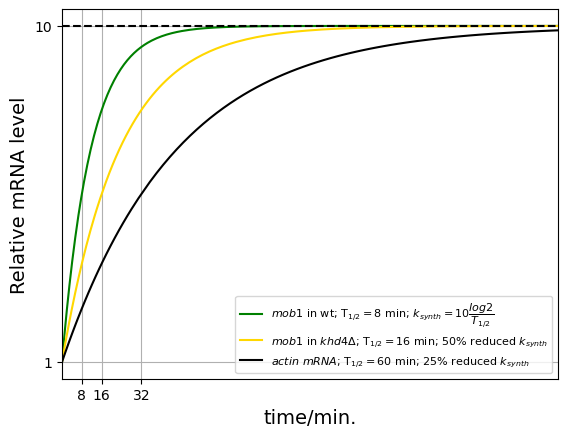

In [76]:
colors = ['g', 'gold', 'k']
syn = [np.log(2)/8 * 10, np.log(2)/16 * 10, np.log(2)/32 * 10]
dek = [8, 16, 32]
labels = ['$\it{mob1}$ in wt; T$_{1/2}=$8 min; $k_{synth}=10\dfrac{log 2}{T_{1/2}}$', 
          '$\it{mob1}$ in $\it{khd4}\Delta$; T$_{1/2}=$16 min; 50% reduced $k_{synth}$', 
          '$\it{actin~mRNA}$; T$_{1/2}=$60 min; 25% reduced $k_{synth}$']


fig = plt.figure()
ax = fig.add_subplot(111)
plt.xlim(0,200)


for i,j,k,l in zip(syn, dek, colors, labels):
    s = Simulator(m)
    y0 = {'mRNA': 1}
    m.update_parameters({'kSynth': i, 'kDecay': decay(j)})
    s.initialise(y0)
    t, y = s.simulate(300) #Actually simulating the model until the given time point. The specifc time steps are stored as an array in the variable t
                                    #and the different concentrations in a nested array

    ax.plot(s.get_time(), s.get_variable('mRNA'), color = k,
            label = l)

plt.axhline(y=10, xmin=0, xmax=1, color='black', linestyle = "--")
plt.ylabel('Relative mRNA level', fontsize = 14)
plt.xlabel("time/min.", fontsize = 14)
plt.yticks([1, 10])
plt.xticks(dek)
plt.legend(fontsize=8)
plt.grid()
plt.savefig('RelativeLevels.svg')